# Index

---

+ **Fer2013**  

    1. Loading and preprocessing data
    2. Insights
    3. ResNet transfer learning
    4. Fine tuning
    5. Customized CNN
    6. Data Augmentation
    7. Label smoothing
    8. Test Time Augmentation

+ **Fer2013+**  

    1. Preparing, loading and preprocessing data
    2. Insights
    3. ResNet transfer learning
    4. Fine tuning
    5. Customized CNN
    6. Data Augmentation
    7. Label smoothing
    8. Test Time Augmentation

# Environment

---

In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf

# REVISE
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()


from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import shap
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tqdm import tqdm
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Instructions for updating:
non-resource variables are not supported in the long term


# Fer2013

---

## Loading and preprocessing data

---

In [2]:
def convertToFloat(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

def getImages(row):
    return row[0]

def getNumpyArray(tf_dataset):
    X = list(tf_dataset)
    X = np.concatenate(list(map(getImages,X)))
    return X

def getLabel(row):
    return row[1]

def getLabels(tf_dataset):
    y = list(tf_dataset)
    y = np.concatenate(list(map(getLabel,y)))
    return y

def load_data(image_size=(48, 48),batch_size=64,label_mode='int',dataset=True):
    # Load training, validation and test sets
    ds_train = image_dataset_from_directory(
        'dataset/train',
        validation_split=0.2,
        seed=123,
        subset="training",
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    ds_val = image_dataset_from_directory(
        'dataset/train',
        validation_split=0.2,
        seed=123,
        subset="validation",
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    ds_test = image_dataset_from_directory(
        'dataset/test',
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    class_names = np.array(ds_train.class_names)
    ds_train = (
        ds_train
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_val = (
        ds_val
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_test = (
        ds_test
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    return ds_train,ds_val,ds_test,class_names

In [3]:
ds_train,ds_val,ds_test,class_names = load_data(batch_size=128,label_mode='categorical')

Found 28708 files belonging to 7 classes.
Using 22967 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 28708 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [4]:
# to use the pretrained model
image_size = (224, 224)
ds_train_224,ds_val_224,ds_test_224,class_names = load_data(image_size=image_size)

Found 28708 files belonging to 7 classes.
Using 22967 files for training.
Found 28708 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [5]:
X_train = getNumpyArray(ds_train)
print(f"Data is already normalized: max is {np.ndarray.max(X_train)} and min is {np.ndarray.min(X_train)} with {np.ndarray.std(X_train):.2f} standard deviation")

Data is already normalized: max is 1.0 and min is 0.0 with 0.26 standard deviation


## Getting insights

---

In [6]:
print('There are\033[1m {}\033[0m classes:\033[1m'.format(len(class_names)))
for class_name in class_names:
    print('\t'+class_name.upper())
print("\033[0m", end="")

There are 7 classes:
	ANGRY
	DISGUST
	FEAR
	HAPPY
	NEUTRAL
	SAD
	SURPRISE


In [10]:
y_train = getLabels(ds_train)
y_val = getLabels(ds_val)
y_test = getLabels(ds_test)

y_train_224 = getLabels(ds_train_224)
y_val_224 = getLabels(ds_val_224)
y_test_224 = getLabels(ds_test_224)

In [14]:
y_train_224.shape

(22967,)

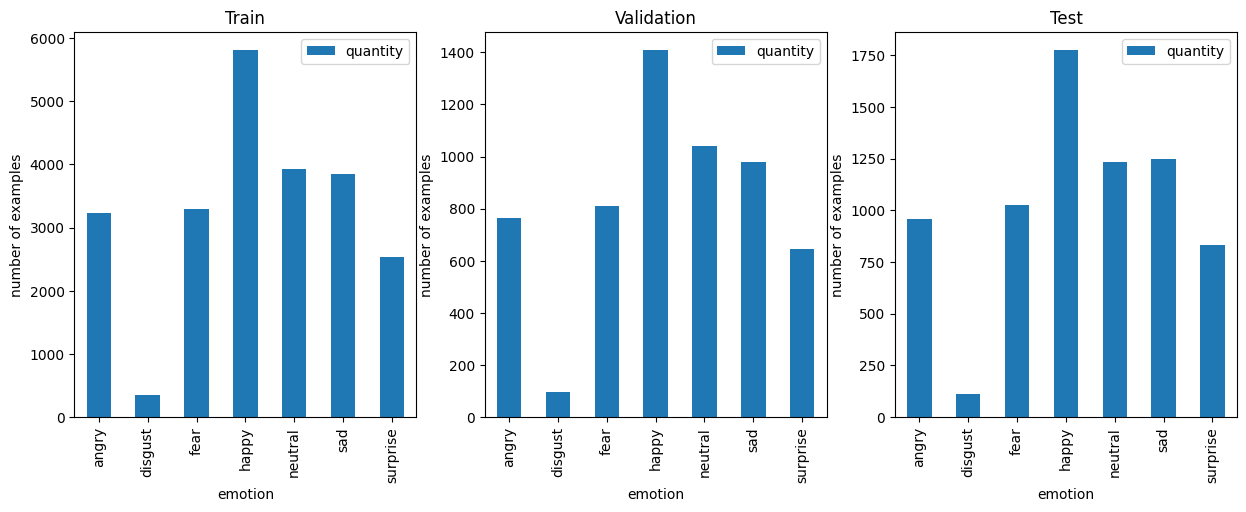

In [17]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
pd.DataFrame({'emotion':class_names[y_train_224], 'quantity': np.ones(y_train_224.shape)}).groupby('emotion').count().plot(ax=axes[0], kind='bar')
pd.DataFrame({'emotion':class_names[y_val_224], 'quantity': np.ones(y_val_224.shape)}).groupby('emotion').count().plot(ax=axes[1], kind='bar')
pd.DataFrame({'emotion':class_names[y_test_224], 'quantity': np.ones(y_test_224.shape)}).groupby('emotion').count().plot(ax=axes[2], kind='bar');

titles = ['Train','Validation','Test']
for i in range(3):
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('number of examples'); 

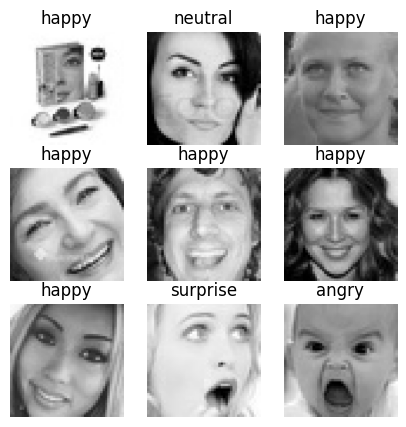

In [19]:
X_train_224 = getNumpyArray(ds_train_224)
plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_224[i])
  plt.title(class_names[y_train_224[i]])
  plt.axis("off");

## ResNet transfer learning

---

In [12]:
model = tf.keras.Sequential([
                                # tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224))),
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=False),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           multiple                  0         
                                                                 
 keras_layer_1 (KerasLayer)  multiple                  23561152  
                                                                 
 dense_1 (Dense)             multiple                  14343     
                                                                 
Total params: 23,575,495
Trainable params: 14,343
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# history = model.fit(
#     ds_train_224,
#     validation_data=ds_val_224,
#     epochs=10,
# )
# model.save('models/resnet.h5')
# with open('models/resnet.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [56]:
model = load_model('models/resnet.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_resnet.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [30]:
def evaluate(model,history,ds_train,ds_val,ds_test,shap_values=None,one_hot_encoded=False,class_names_variable=class_names,isPlus=False):
    y_train = getLabels(ds_train)
    y_val = getLabels(ds_val)
    y_test = getLabels(ds_test)

    f,axes = plt.subplots(1,2,figsize=(20,5))
    history_frame = pd.DataFrame(history)
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

    if(one_hot_encoded):
        y_train = np.argmax(y_train,axis=1)
        y_val = np.argmax(y_val,axis=1)
        y_test = np.argmax(y_test,axis=1)
    print("Calculating training results:")
    y_train_predictions = np.argmax(model.predict(ds_train),axis=1)
    print("Calculating validation results:")
    y_val_predictions = np.argmax(model.predict(ds_val),axis=1)
    print("Calculating test results:")
    y_test_predictions = np.argmax(model.predict(ds_test),axis=1)

    if(isPlus):
        f, axes= plt.subplots(1,3,figsize=(30,15))
    else:
        f, axes= plt.subplots(1,3,figsize=(30,5))
    accuracies = []
    accuracies.append(round(100*accuracy_score(y_train, y_train_predictions),2))
    mat = confusion_matrix(y_train, y_train_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[0]);

    accuracies.append(round(100*accuracy_score(y_val, y_val_predictions),2))
    mat = confusion_matrix(y_val, y_val_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[1]);

    accuracies.append(round(100*accuracy_score(y_test, y_test_predictions),2))
    mat = confusion_matrix(y_test,y_test_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[2]);

    for i in range(3):
        axes[i].set_xlabel('Predicted emotions');axes[i].set_ylabel('True emotions'); 
        axes[i].set_title('Confusion Matrix '+titles[i]+ " (accuracy: {}%)".format(accuracies[i])); 
        axes[i].xaxis.set_ticklabels(class_names_variable); axes[i].yaxis.set_ticklabels(class_names_variable);
    if(shap_values is not None):
        fig,axes = plt.subplots(1,len(class_names_variable)+1,figsize=(20,3))
        axes[0].set_axis_off()
        axes[0].set_title("REAL CLASSES ->")
        image = plt.imread('images/predicted.png')
        axes[0].imshow(image)
        for i in range(1,len(class_names_variable)+1):
            axes[i].set_axis_off()
            axes[i].set_title(class_names_variable[i-1])
            axes[i].imshow(one_example_per_class[i-1])
        shap.image_plot(shap_values,one_example_per_class)

Calculating training results:
359/359 [==============================] - 185s 515ms/step
Calculating validation results:
90/90 [==============================] - 48s 544ms/step
Calculating test results:
113/113 [==============================] - 61s 543ms/step


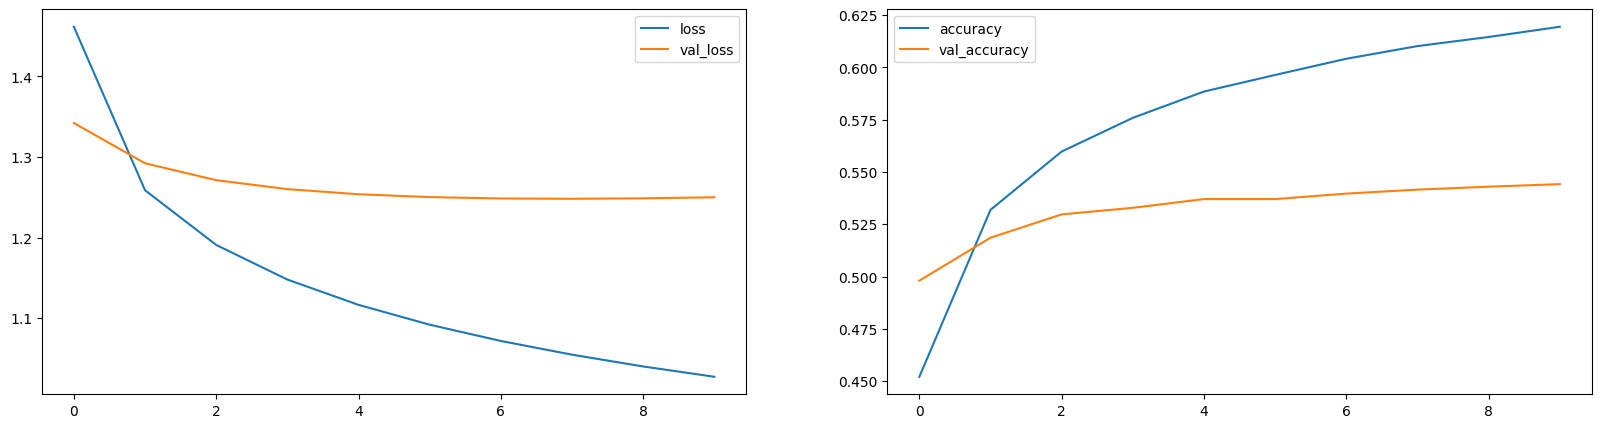

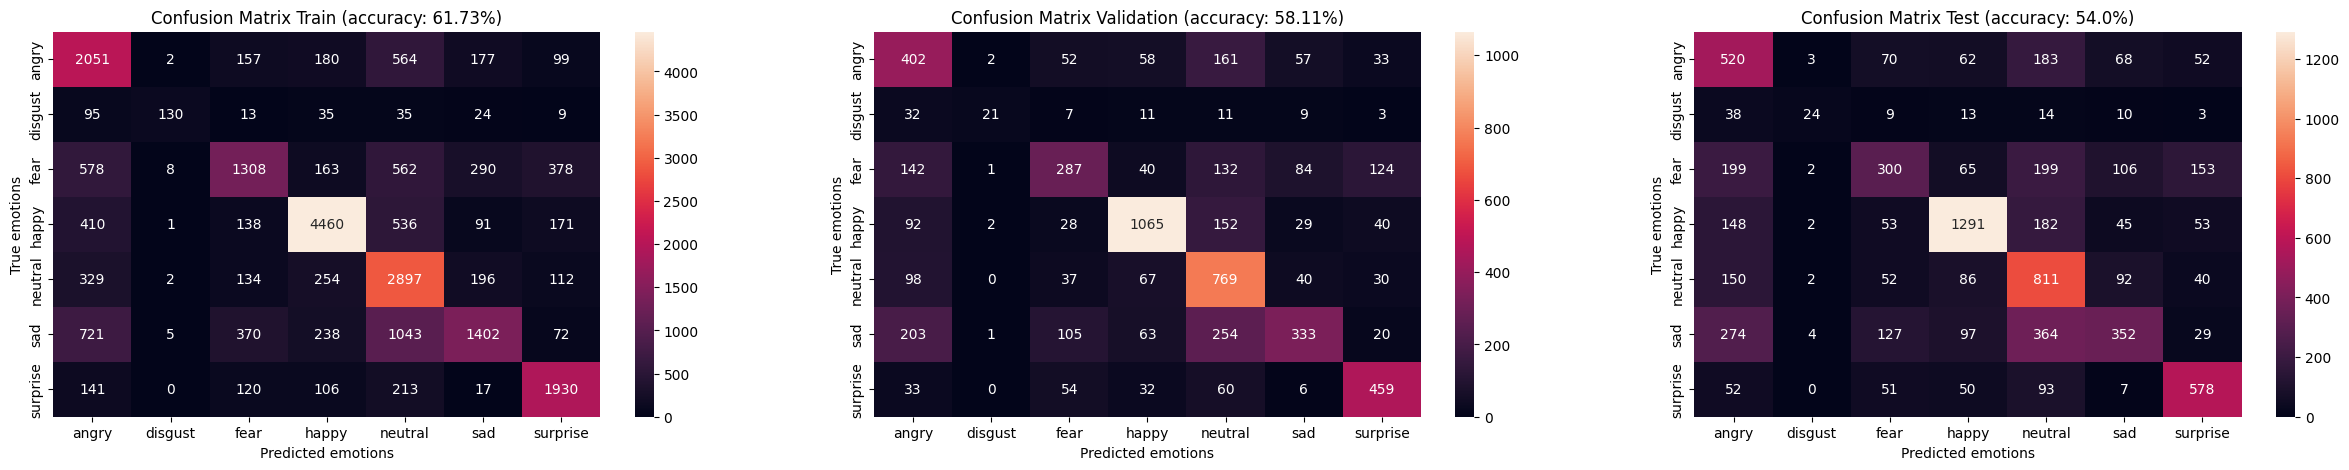

In [58]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224)

## Fine tuning

---

In [ ]:
model = tf.keras.Sequential([
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=True),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

In [ ]:
# history = model.fit(
#     ds_train_224,
#     validation_data=ds_val_224,
#     epochs=5,
# )
# model.save('models/my_model_fine_tuned.h5')
# with open('models/history_fine_tuned.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [ ]:
model = load_model('models/my_model_fine_tuned.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_fine_tuned.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [ ]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224)

## Customized CNN

---

In [67]:
def createModel(loss='categorical_crossentropy'):
    tf.random.set_seed(1)
    model= tf.keras.models.Sequential([
        preprocessing.Normalization(),

        Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(64,(3,3), padding='same', activation='relu' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128,(5,5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
            
        Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),
            
        Dense(512,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(7, activation='softmax')
    ])
    model.build([None, 48, 48, 3])
    model.compile(
        # its default learning rate is already 0.001
        optimizer=Adam(),
        loss=loss,
        metrics=['accuracy'],
    )
    return model

I'll search for the best learning rate posible with GridSearch

In [ ]:
# X_train = getNumpyArray(ds_train)
# y_train = getLabels(ds_train)
# X_val = getNumpyArray(ds_val)
# y_val = getLabels(ds_val)
# X = np.vstack((X_train,X_val))
# y = np.concatenate((y_train,y_val))

# model = KerasClassifier(model=createModel,batch_size=64, epochs=5)
# learn_rate = [0.001, 0.0001,0.00001]
# param_grid = dict(optimizer__learning_rate=learn_rate)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3)
# grid_result = grid.fit(X,y)

# joblib.dump(grid.best_params_, 'best_learning_rate_custom_model.pkl')

In [ ]:
best_learning_rate = joblib.load('best_learning_rate_custom_model.pkl')
print(f"The best learning rate amongst the ones that have been tried is {best_learning_rate['optimizer__learning_rate']}")

In [45]:
model= createModel()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  multiple                 7         
 ion)                                                            
                                                                 
 conv2d_10 (Conv2D)          multiple                  896       
                                                                 
 conv2d_11 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_12 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                      

In [46]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=30,
# )
# model.save('models/custom.h5')
# with open('models/history_custom.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/30
180/180 [==============================] - 48s 260ms/step - loss: 6.3497 - accuracy: 0.2556 - val_loss: 3.9593 - val_accuracy: 0.2458
Epoch 2/30
180/180 [==============================] - 45s 251ms/step - loss: 2.4329 - accuracy: 0.4151 - val_loss: 2.9715 - val_accuracy: 0.2453
Epoch 3/30
180/180 [==============================] - 45s 253ms/step - loss: 1.9928 - accuracy: 0.4986 - val_loss: 2.6659 - val_accuracy: 0.3668
Epoch 4/30
180/180 [==============================] - 46s 254ms/step - loss: 1.8846 - accuracy: 0.5615 - val_loss: 2.4155 - val_accuracy: 0.4151
Epoch 5/30
180/180 [==============================] - 45s 250ms/step - loss: 1.8952 - accuracy: 0.6071 - val_loss: 2.5186 - val_accuracy: 0.4255
Epoch 6/30
180/180 [==============================] - 45s 252ms/step - loss: 1.8678 - accuracy: 0.6457 - val_loss: 2.9991 - val_accuracy: 0.2867
Epoch 7/30
180/180 [==============================] - 46s 258ms/step - loss: 1.8361 - accuracy: 0.6818 - val_loss: 2.5668 - val_ac

In [51]:
model = load_model('models/custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [49]:
one_example_per_class = np.empty((len(class_names),)+X_train[0].shape)
for i in range(len(class_names)):
    one_example_per_class[i] = X_train[np.where(y_train == i)[0][0]]

In [ ]:
# shapExplainer = shap.DeepExplainer(model,X_train[:100])
# shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
# shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)
# shap_values = shapExplainer.shap_values(one_example_per_class)
# with open("shap_values", "wb") as fp:
#     pickle.dump(shap_values, fp)

In [53]:
with open("shap_values", "rb") as fp:
    shap_values = pickle.load(fp)

Calculating training results:
180/180 [==============================] - 12s 67ms/step
Calculating validation results:
45/45 [==============================] - 3s 67ms/step
Calculating test results:
57/57 [==============================] - 4s 66ms/step


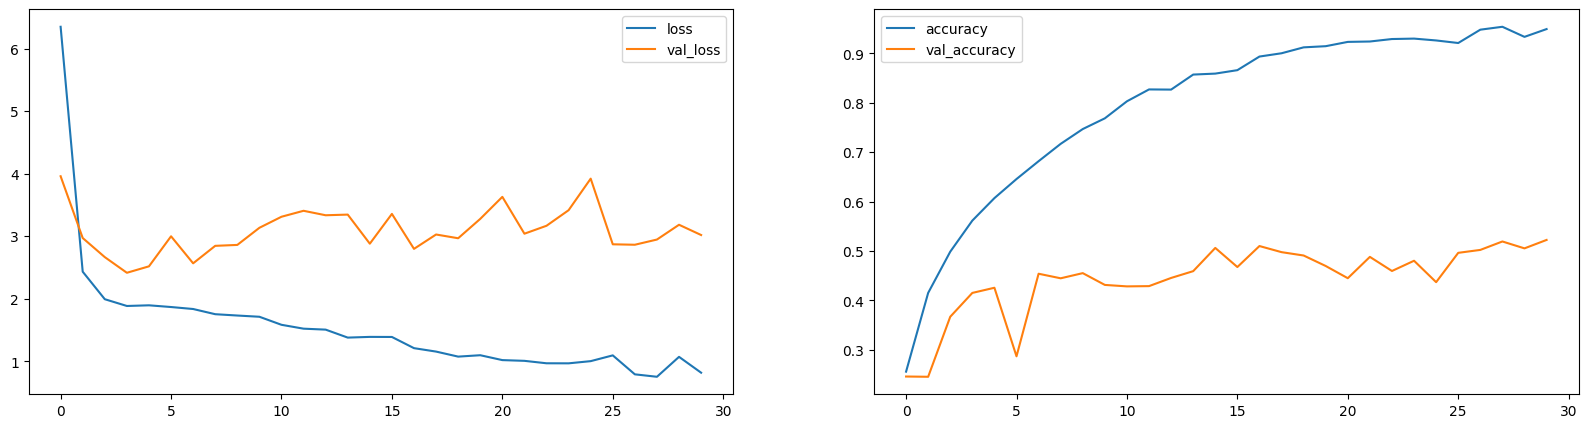

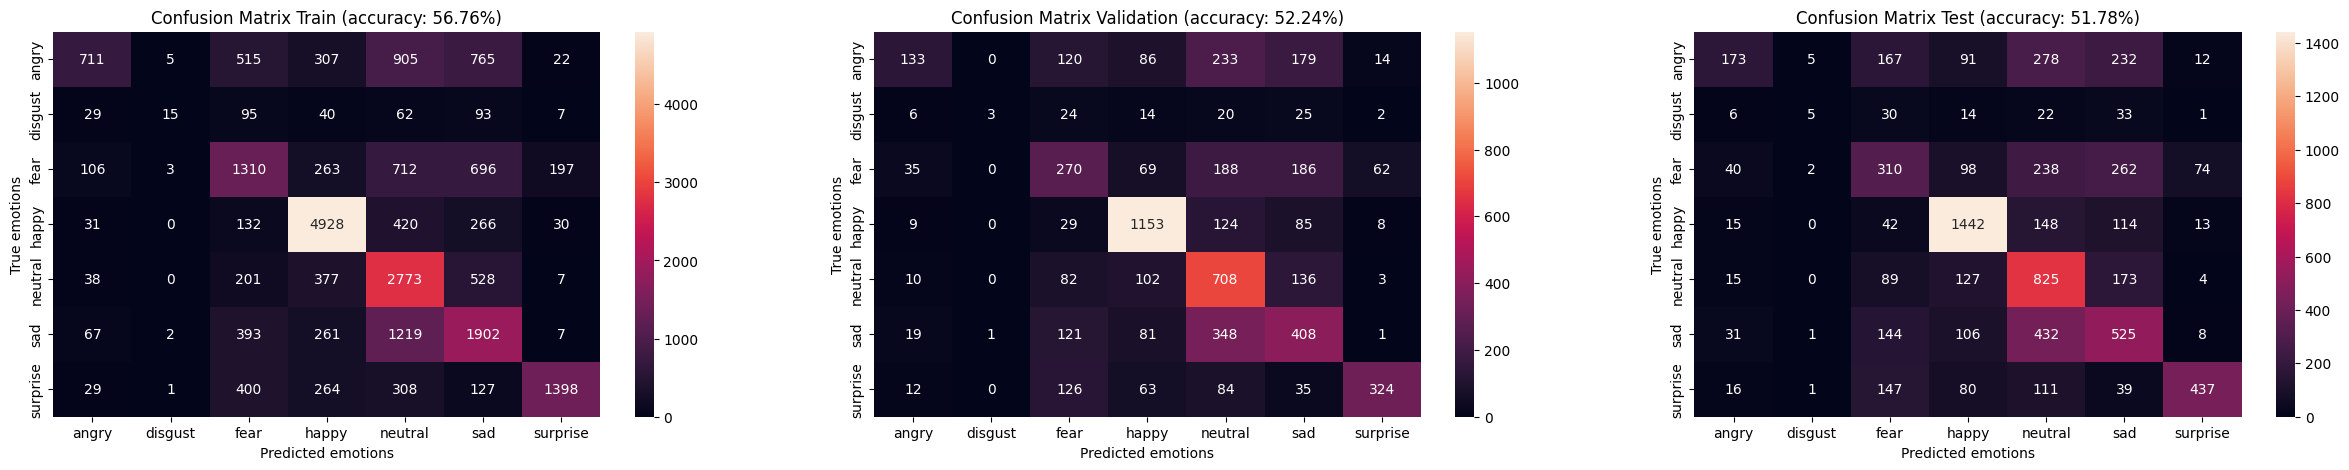

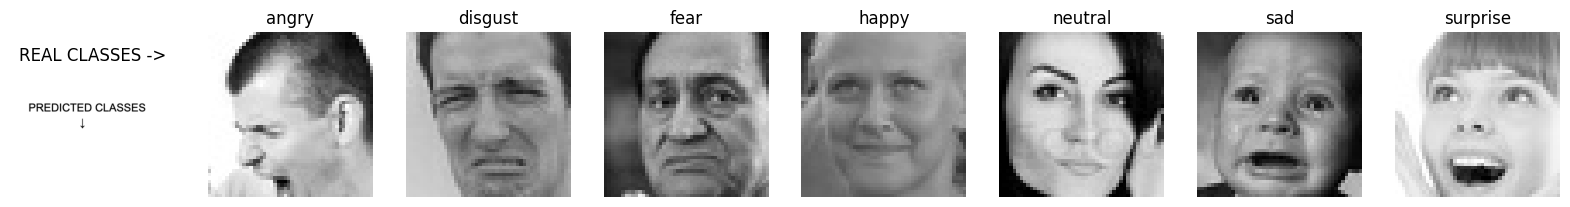

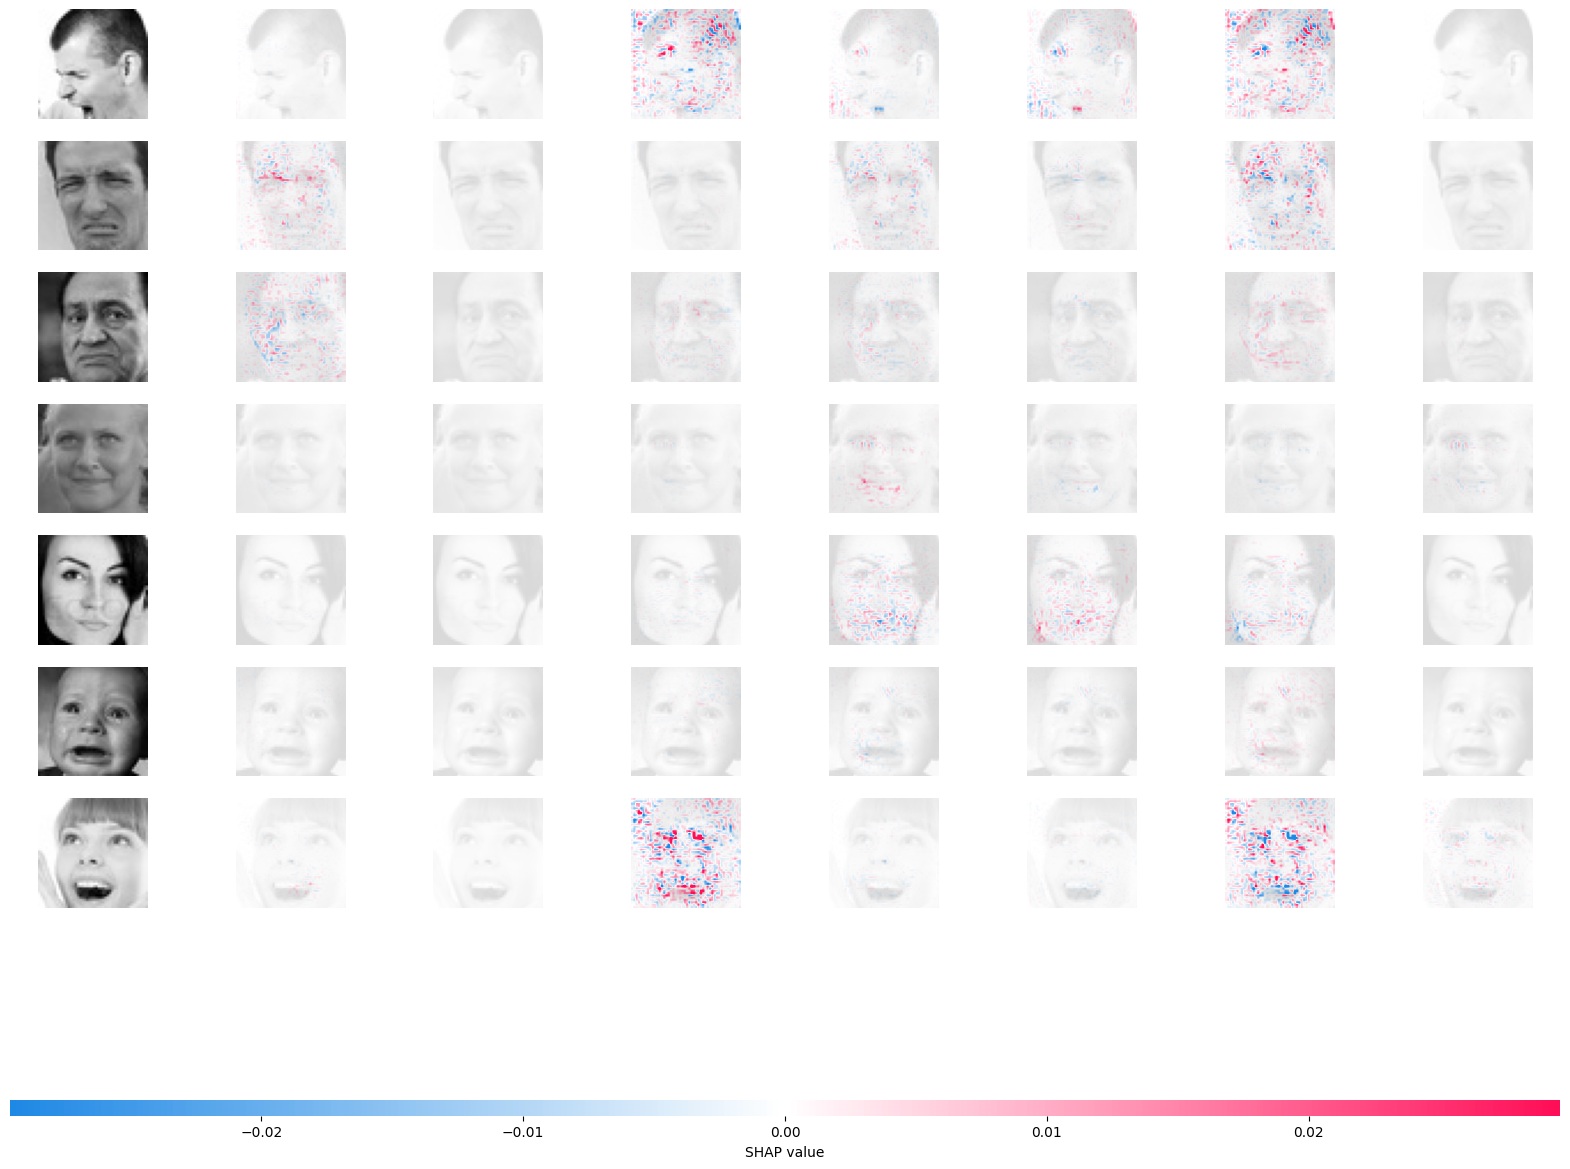

In [55]:
evaluate(model,history2,ds_train,ds_val,ds_test,shap_values=shap_values,one_hot_encoded=True)

## Data augmentation

---

In [61]:
X_train = getNumpyArray(ds_train)
X_val = getNumpyArray(ds_val)
X_test = getNumpyArray(ds_test)
y_train = getLabels(ds_train)
y_val = getLabels(ds_val)
y_test = getLabels(ds_test)

In [62]:
# model = load_model('models/custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=5)
# train_datagen.fit(X_train)

# history = model.fit(train_datagen.flow(X_train, y_train),
#                               epochs=5,
#                               validation_data=ds_val)
# model.save('models/augmented.h5')
# with open('models/history_augmented.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
718/718 [==============================] - 64s 86ms/step - loss: 4.2808 - accuracy: 0.3393 - val_loss: 2.3662 - val_accuracy: 0.4339
Epoch 2/5
718/718 [==============================] - 61s 85ms/step - loss: 2.4478 - accuracy: 0.4360 - val_loss: 2.3181 - val_accuracy: 0.4193
Epoch 3/5
718/718 [==============================] - 62s 86ms/step - loss: 2.1831 - accuracy: 0.4698 - val_loss: 2.2430 - val_accuracy: 0.4997
Epoch 4/5
718/718 [==============================] - 64s 89ms/step - loss: 2.0694 - accuracy: 0.4863 - val_loss: 1.9381 - val_accuracy: 0.4952
Epoch 5/5
718/718 [==============================] - 66s 93ms/step - loss: 1.9323 - accuracy: 0.4995 - val_loss: 1.7912 - val_accuracy: 0.5219


In [63]:
model = load_model('models/augmented.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 13s 73ms/step
Calculating validation results:
45/45 [==============================] - 3s 71ms/step
Calculating test results:
57/57 [==============================] - 4s 75ms/step


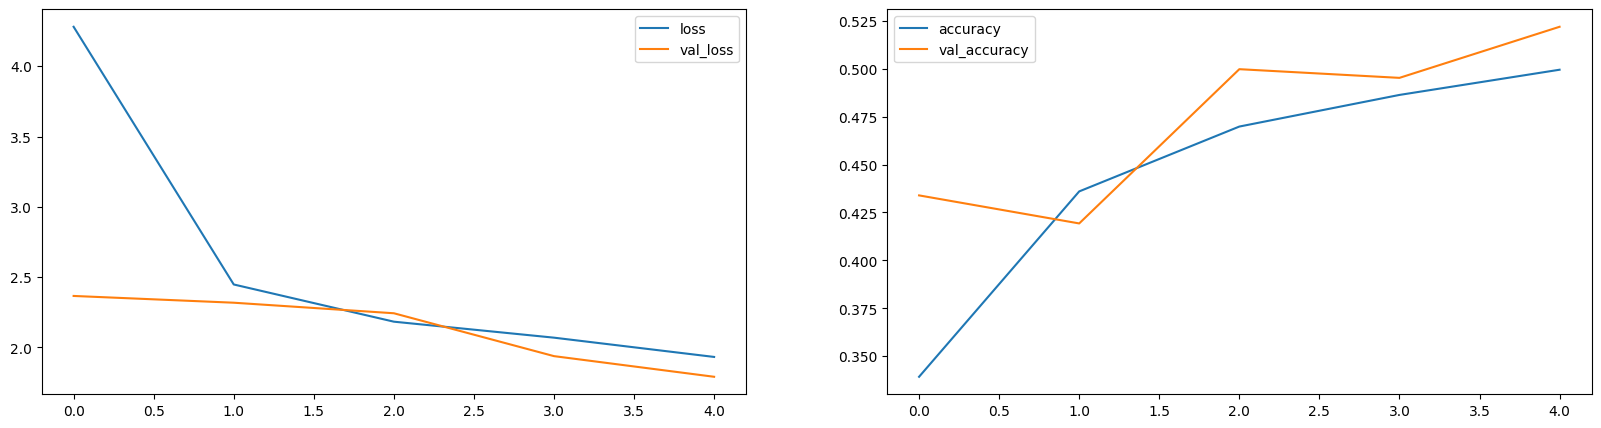

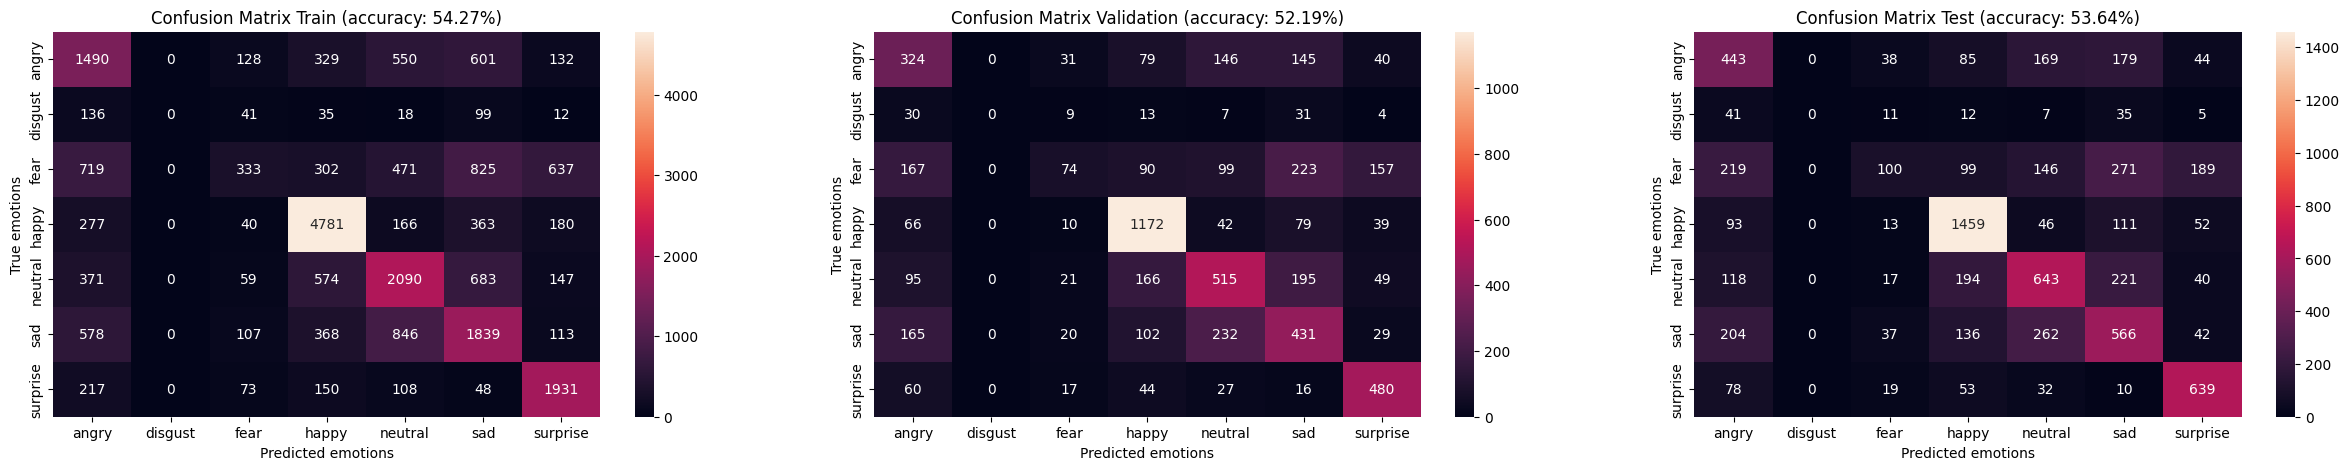

In [65]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

## Label smoothing

---

In [72]:
model = load_model('models/augmented.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  multiple                 7         
 ion)                                                            
                                                                 
 conv2d_10 (Conv2D)          multiple                  896       
                                                                 
 conv2d_11 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_12 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                      

In [73]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=5,
# )
# model.save('models/label_smoothed.h5')
# with open('models/history_label_smoothed.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
180/180 [==============================] - 50s 265ms/step - loss: 1.7711 - accuracy: 0.5644 - val_loss: 1.8662 - val_accuracy: 0.5060
Epoch 2/5
180/180 [==============================] - 45s 252ms/step - loss: 1.5380 - accuracy: 0.6548 - val_loss: 1.7951 - val_accuracy: 0.5311
Epoch 3/5
180/180 [==============================] - 45s 252ms/step - loss: 1.4824 - accuracy: 0.7278 - val_loss: 1.8919 - val_accuracy: 0.5419
Epoch 4/5
180/180 [==============================] - 47s 264ms/step - loss: 1.3423 - accuracy: 0.8110 - val_loss: 1.9991 - val_accuracy: 0.5384
Epoch 5/5
180/180 [==============================] - 48s 266ms/step - loss: 1.2905 - accuracy: 0.8584 - val_loss: 2.0716 - val_accuracy: 0.5602


In [75]:
model = load_model('models/label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 12s 67ms/step
Calculating validation results:
45/45 [==============================] - 3s 70ms/step
Calculating test results:
57/57 [==============================] - 4s 70ms/step


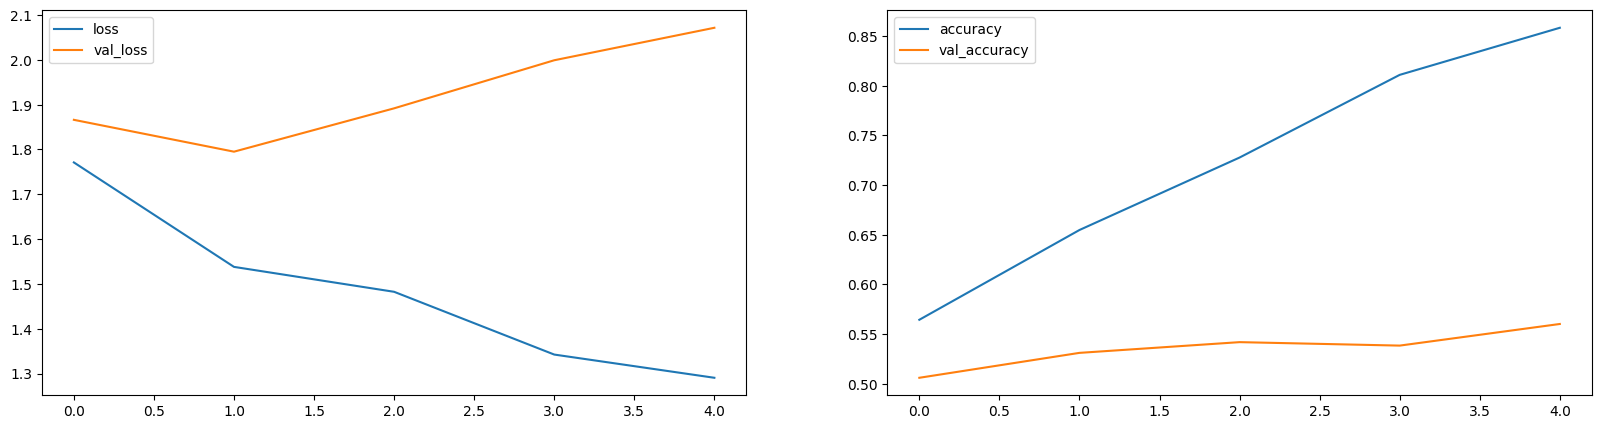

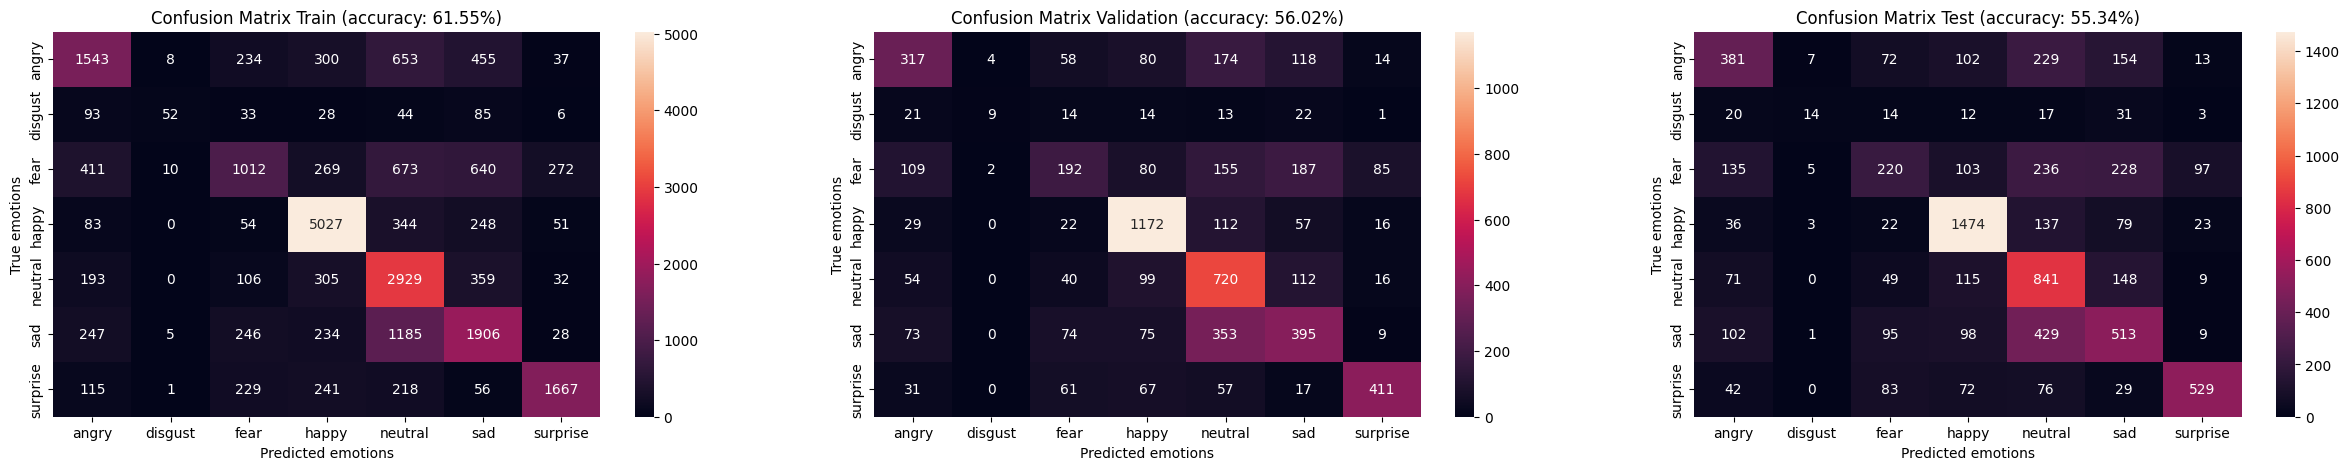

In [76]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

## Test Time Augmentation

---

In [46]:
def predictWithTTA(test_set,model,data_generator,tta_steps=3,batch_size=128):
    x_test = getNumpyArray(test_set)
    predictions = []
    for i in tqdm(range(tta_steps)):
        preds = model.predict(data_generator.flow(x_test, batch_size=batch_size, shuffle=False), steps = len(x_test)/batch_size)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)
    return predictions

def calculateAccuracyWithTTA(test_set,model):
    predictions = predictWithTTA(test_set,model,ImageDataGenerator(horizontal_flip=True,shear_range=5))
    int_predictions = np.argmax(predictions,axis=1)
    print(f"Accuracy obtained with Test Time Augmentation is: {round(100*accuracy_score(np.argmax(getLabels(test_set),axis=1), int_predictions),2)}%")

In [80]:
model = load_model('models/label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
calculateAccuracyWithTTA(ds_test,model)

  0%|          | 0/3 [00:00<?, ?it/s]

56/56 [==============================] - 6s 105ms/step


 33%|███▎      | 1/3 [00:06<00:12,  6.19s/it]

56/56 [==============================] - 6s 104ms/step


 67%|██████▋   | 2/3 [00:12<00:05,  5.99s/it]

56/56 [==============================] - 6s 104ms/step


100%|██████████| 3/3 [00:17<00:00,  5.95s/it]

Accuracy obtained with Test Time Augmentation is: 55.06%


# Fer2013+

---

## Preparing, loading and preprocessing data

---

joining both csv: fer2013 and fer2013 plus

In [ ]:
# fer = pd.read_csv('dataset_fer+/originals/fer2013.csv')
# fer_plus_labels = pd.read_csv('dataset_fer+/originals/fer2013new.csv')

# fer = fer.drop(['emotion','Usage'], axis=1)
# fer_plus_labels = fer_plus_labels.drop(['Image name'], axis=1)
# fer_plus = pd.concat([fer,fer_plus_labels], axis=1)
# training = fer_plus.loc[fer_plus['Usage'] == 'Training']
# validation = fer_plus.loc[fer_plus['Usage'] == 'PublicTest']
# test = fer_plus.loc[fer_plus['Usage'] == 'PrivateTest']
# training = training.drop(['Usage'], axis=1)
# validation = validation.drop(['Usage'], axis=1)
# test = test.drop(['Usage'], axis=1)

# training.to_csv("dataset_fer+/training.csv", index=False)
# validation.to_csv("dataset_fer+/validation.csv", index=False)
# test.to_csv("dataset_fer+/test.csv", index=False)

In [21]:
training = pd.read_csv('dataset_fer+/training.csv')
validation = pd.read_csv('dataset_fer+/validation.csv')
test = pd.read_csv('dataset_fer+/test.csv')

In [22]:
display(training)
display(validation)
display(test)

,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,4,0,0,1,3,2,0,0,0,0
1,151 150 147 155 148 133 111 140 170 174 182 15...,6,0,1,1,0,0,0,0,2,0
2,231 212 156 164 174 138 161 173 182 200 106 38...,5,0,0,3,1,0,0,0,1,0
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,4,0,0,4,1,0,0,0,1,0
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,9,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
28704,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,0,0,1,0,0,0,9,0,0,0
28705,114 112 113 113 111 111 112 113 115 113 114 11...,0,0,1,0,9,0,0,0,0,0
28706,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,0,0,1,9,0,0,0,0,0,0
28707,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,5,0,0,1,0,1,0,0,3,0


,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,4,0,0,0,1,0,0,4,1,0
1,156 184 198 202 204 207 210 212 213 214 215 21...,1,0,0,1,0,2,0,6,0,0
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,7,0,0,0,2,0,0,1,0,0
3,205 203 236 157 83 158 120 116 94 86 155 180 2...,5,5,0,0,0,0,0,0,0,0
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,0,10,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3584,178 176 172 173 173 174 176 173 166 166 206 22...,3,0,1,4,0,0,0,0,2,0
3585,25 34 42 44 42 47 57 59 59 58 54 51 50 56 63 6...,0,10,0,0,0,0,0,0,0,0
3586,255 255 255 255 255 255 255 255 255 255 255 25...,4,0,0,4,1,0,0,0,1,0
3587,33 25 31 36 36 42 69 103 132 163 175 183 187 1...,8,0,0,1,0,0,0,1,0,0


,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,0,0,0,0,2,1,0,7,0,0
1,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,0,0,0,0,0,0,0,0,0,10
2,232 240 241 239 237 235 246 117 24 24 22 13 12...,3,0,0,5,0,0,0,0,2,0
3,200 197 149 139 156 89 111 58 62 95 113 117 11...,6,0,1,2,0,0,0,0,1,0
4,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,0,0,4,0,1,2,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3584,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,8,0,0,2,0,0,0,0,0,0
3585,178 174 172 173 181 188 191 194 196 199 200 20...,0,0,0,0,0,0,0,0,0,10
3586,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,0,0,0,0,7,1,0,2,0,0
3587,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,0,10,0,0,0,0,0,0,0,0


In [23]:
def convertPixelsAsStringWithSpacesToNumpyArrayOfInt(pixels):
    pixels = pixels.split(" ")
    pixels = np.array(list(map(int, pixels))).reshape(48,48)
    pixels = np.dstack((pixels,pixels,pixels))
    return pixels

splits = [training,validation,test]
for split in splits:
    for n_image in tqdm(range(split.shape[0])):
        split.iloc[n_image,0] = [convertPixelsAsStringWithSpacesToNumpyArrayOfInt(split.iloc[n_image,0])]

100%|██████████| 3589/3589 [00:01<00:00, 3327.41it/s]


In [24]:
def getInside(list):
    return list[0]

X_train_plus = np.array(list(training.iloc[:,0].map(getInside)))/255
X_val_plus = np.array(list(validation.iloc[:,0].map(getInside)))/255
X_test_plus = np.array(list(test.iloc[:,0].map(getInside)))/255
class_names_plus = list(training.iloc[:,-10:].columns)

In [25]:
bs = 128
ds_train_plus = tf.data.Dataset.from_tensor_slices((X_train_plus, training.iloc[:,-10:])).batch(bs)
ds_val_plus = tf.data.Dataset.from_tensor_slices((X_val_plus, validation.iloc[:,-10:])).batch(bs)
ds_test_plus = tf.data.Dataset.from_tensor_slices((X_test_plus, test.iloc[:,-10:])).batch(bs)

ds_train_plus = (
    ds_train_plus
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val_plus = (
    ds_val_plus
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test_plus = (
    ds_test_plus
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Insights

---

## ResNet transfer learning

---

In [90]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224))),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names_plus), activation='softmax')
])

model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           multiple                  0         
                                                                 
 keras_layer_2 (KerasLayer)  multiple                  23561152  
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 batch_normalization_30 (Bat  multiple                 8192      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            multiple                  524544    
                                                                 
 dropout_30 (Dropout)        multiple                  0         
                                                      

In [91]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=30,
# )
# model.save('models/resnet+.h5')
# with open('models/history_resnet+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [92]:
model = load_model('models/resnet+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_resnet+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
225/225 [==============================] - 227s 1s/step
Calculating validation results:
29/29 [==============================] - 30s 1s/step
Calculating test results:
29/29 [==============================] - 30s 1s/step


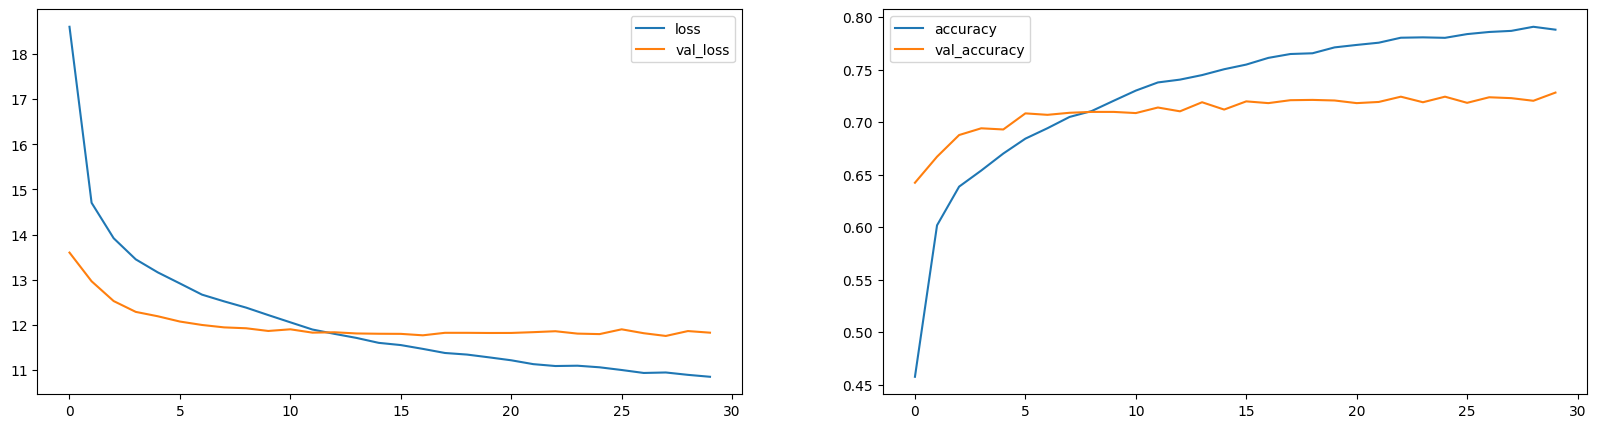

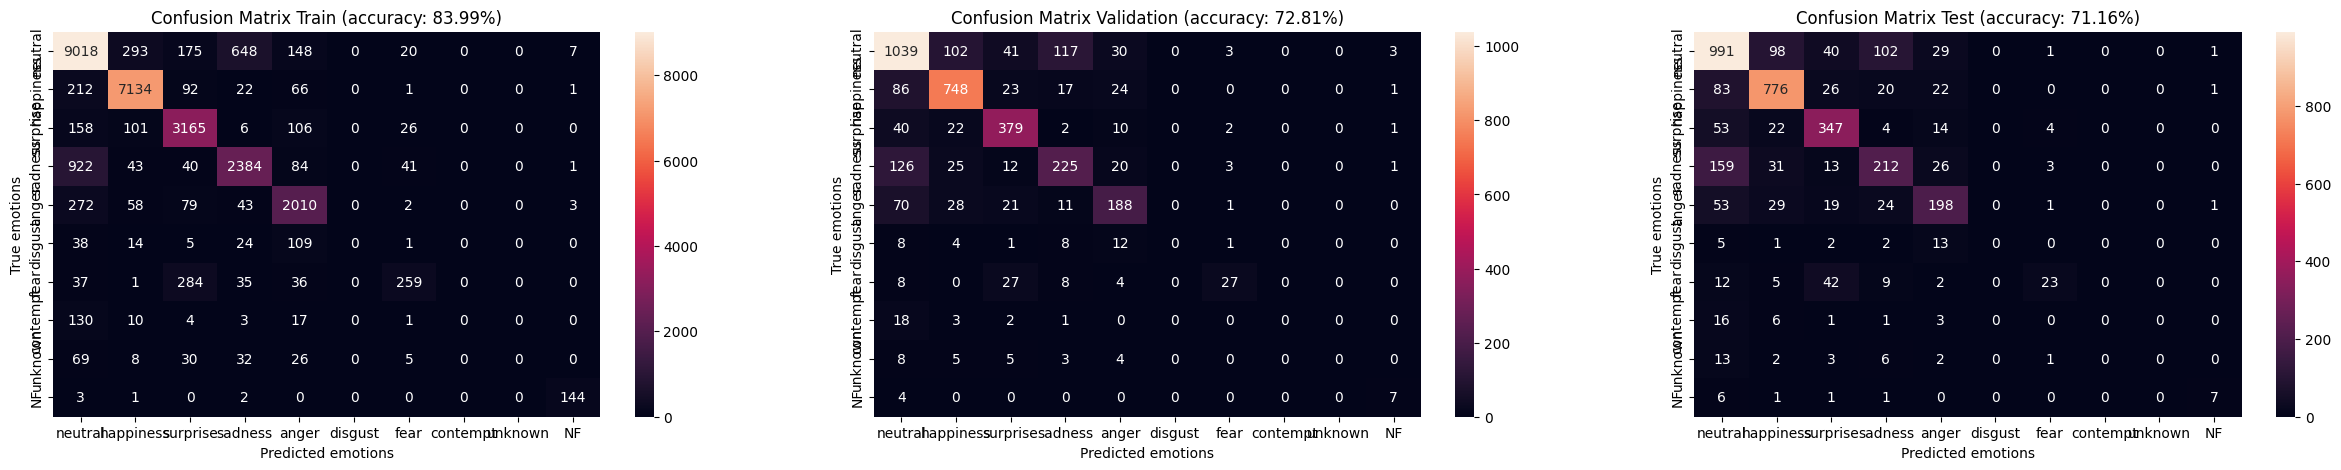

In [93]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,class_names_variable=class_names_plus,one_hot_encoded=True)

## Fine tuning

---

In [94]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224))),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names_plus), activation='softmax')
])

model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           multiple                  0         
                                                                 
 keras_layer_3 (KerasLayer)  multiple                  23561152  
                                                                 
 flatten_6 (Flatten)         multiple                  0         
                                                                 
 batch_normalization_34 (Bat  multiple                 8192      
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            multiple                  524544    
                                                                 
 dropout_33 (Dropout)        multiple                  0         
                                                      

In [95]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=30,
# )
# model.save('models/resnet_fine_tuned+.h5')
# with open('models/history_resnet_fine_tuned+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [ ]:
model = load_model('models/resnet_fine_tuned+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_resnet_fine_tuned+.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [ ]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,class_names_variable=class_names_plus,one_hot_encoded=True)

## Customized CNN

---

In [97]:
tf.random.set_seed(1)
model= tf.keras.models.Sequential([
    preprocessing.Normalization(),

    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(64,(3,3), padding='same', activation='relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128,(5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
        
    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
        
    Dense(512,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(len(class_names_plus), activation='softmax')
])
model.build([None, 48, 48, 3])
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [98]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=30,
# )
# model.save('models/custom+.h5')
# with open('models/history_custom+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [99]:
model = load_model('models/custom+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
225/225 [==============================] - 16s 68ms/step
Calculating validation results:
29/29 [==============================] - 2s 74ms/step
Calculating test results:
29/29 [==============================] - 2s 67ms/step


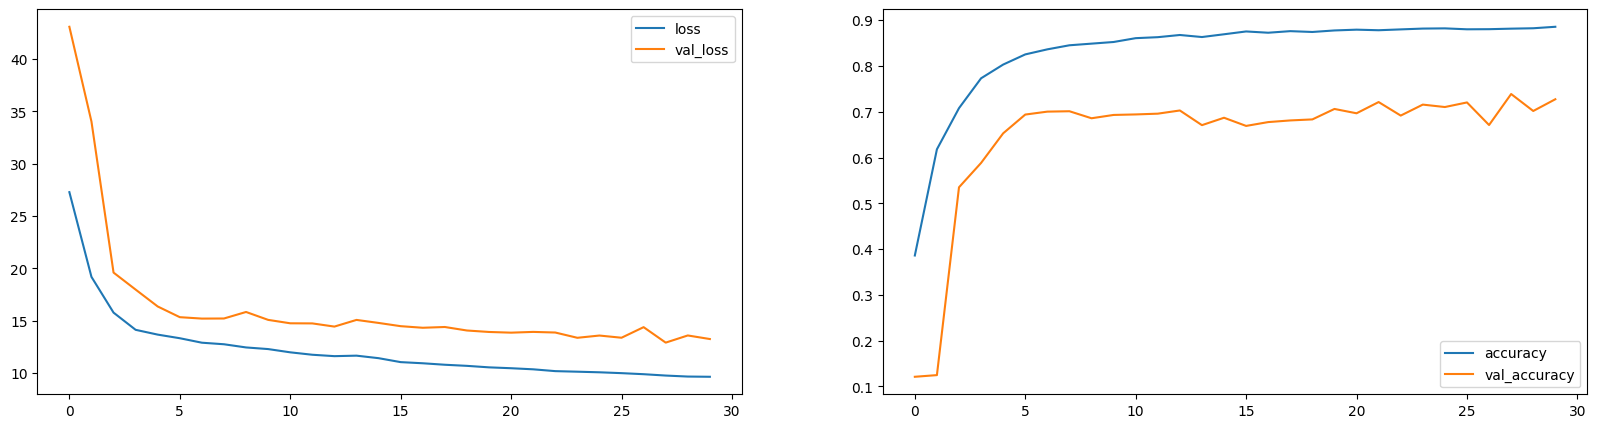

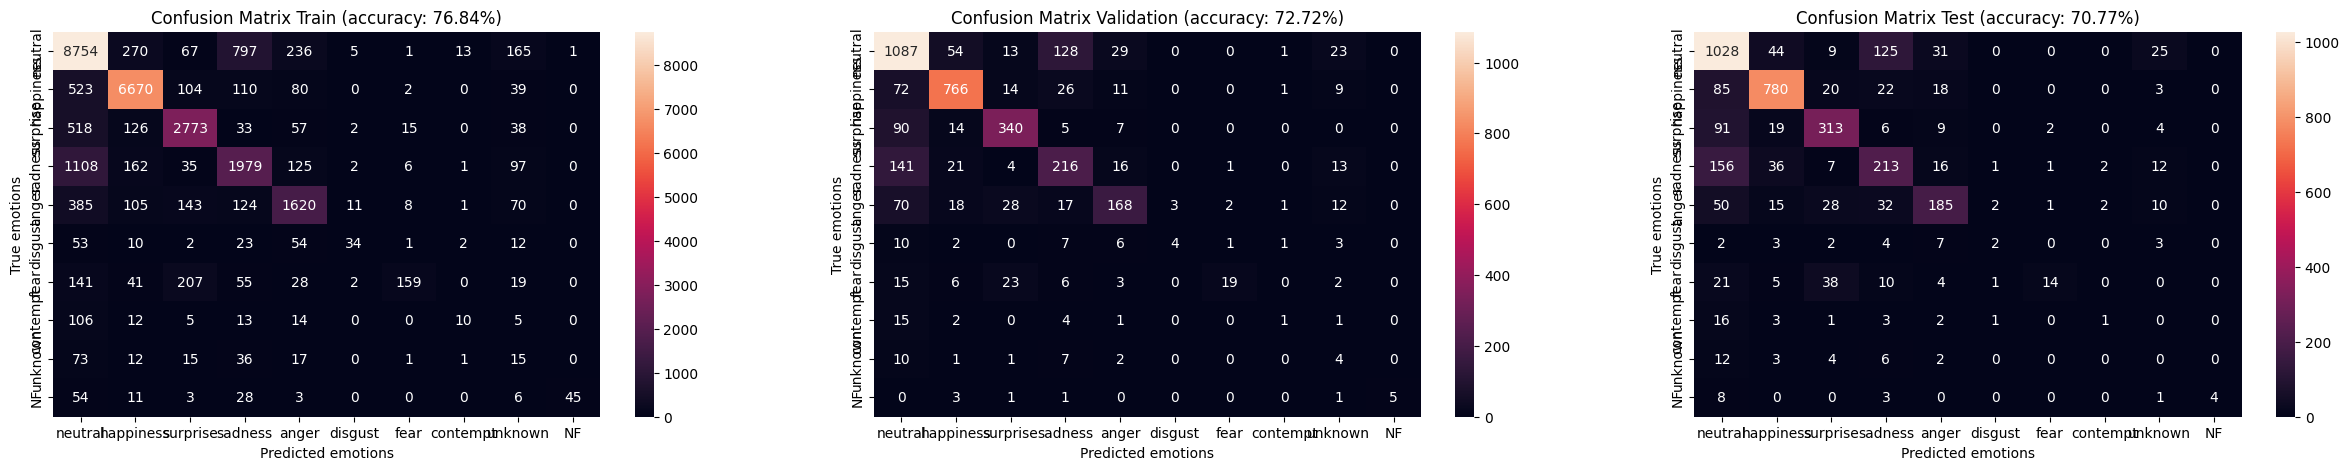

In [100]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,class_names_variable=class_names_plus,one_hot_encoded=True)

## Data Augmentation

---

In [31]:
y_train_plus = getLabels(ds_train_plus)
y_val_plus = getLabels(ds_val_plus)
y_test_plus = getLabels(ds_test_plus)

In [32]:
# model = load_model('models/custom+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=5)
# train_datagen.fit(X_train_plus)

# history = model.fit(train_datagen.flow(X_train_plus, y_train_plus),
#                               epochs=5,
#                               validation_data=ds_val_plus)
# model.save('models/augmented+.h5')
# with open('models/history_augmented+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [33]:
model = load_model('models/augmented+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
225/225 [==============================] - 15s 67ms/step
Calculating validation results:
29/29 [==============================] - 2s 69ms/step
Calculating test results:
29/29 [==============================] - 2s 69ms/step


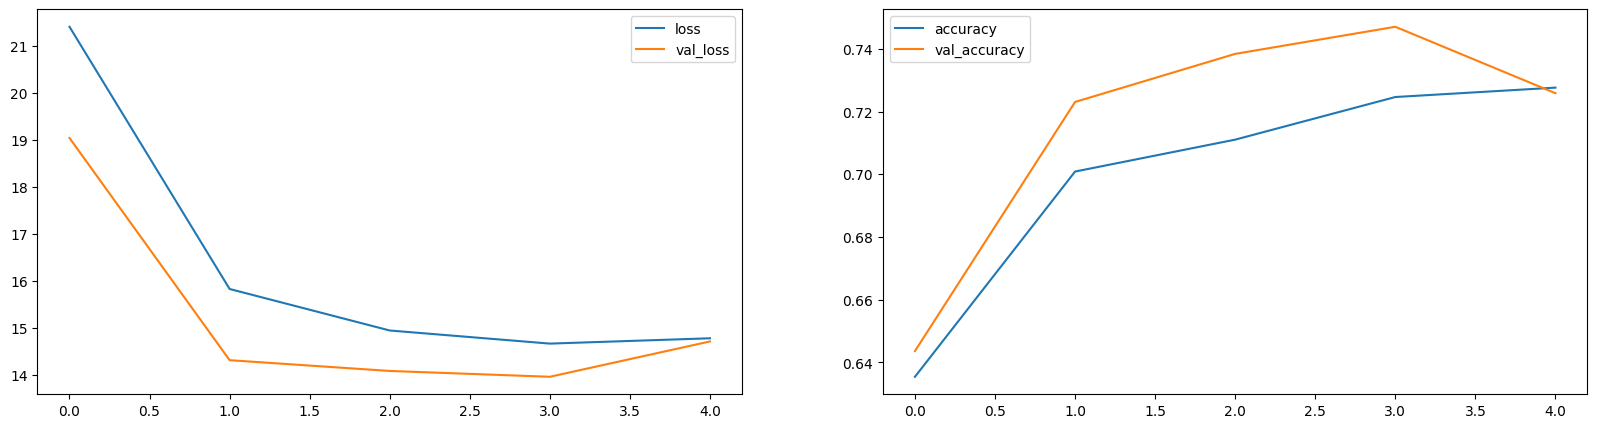

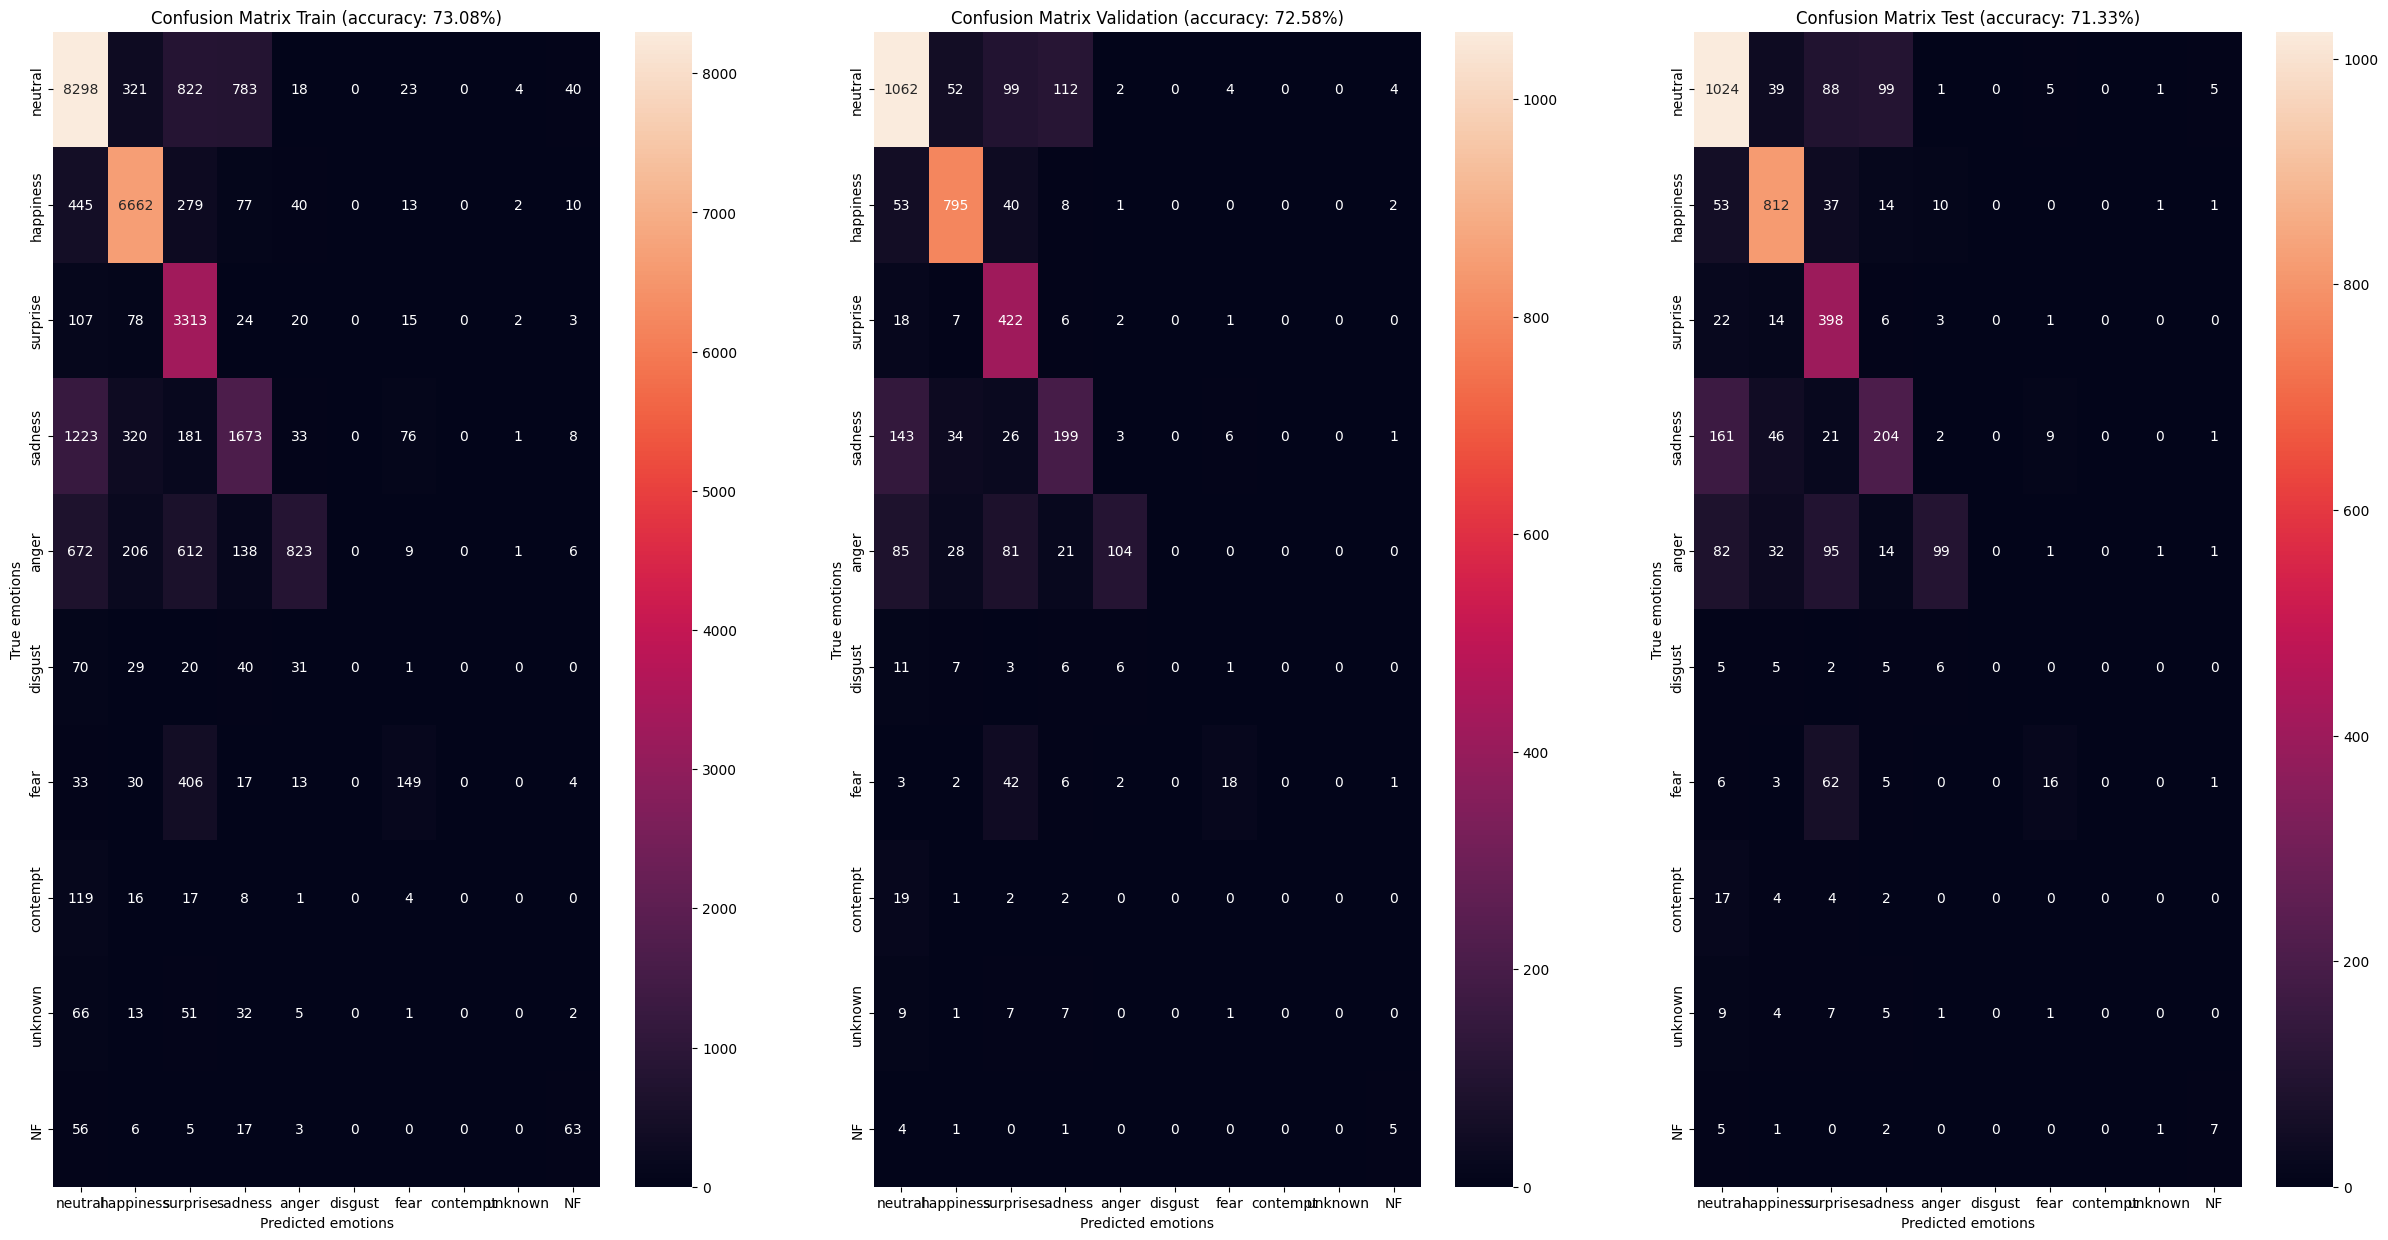

In [36]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

## Label smoothing

---

In [39]:
model = load_model('models/augmented+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             multiple                  896       
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                        

In [40]:
history = model.fit(
    ds_train_plus,
    validation_data=ds_val_plus,
    epochs=5,
)
model.save('models/label_smoothed+.h5')
with open('models/history_label_smoothed+.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/5
225/225 [==============================] - 56s 245ms/step - loss: 12.2535 - accuracy: 0.7681 - val_loss: 11.7150 - val_accuracy: 0.7529
Epoch 2/5
225/225 [==============================] - 55s 242ms/step - loss: 10.9282 - accuracy: 0.8247 - val_loss: 11.9322 - val_accuracy: 0.7545
Epoch 3/5
225/225 [==============================] - 55s 243ms/step - loss: 11.3110 - accuracy: 0.8317 - val_loss: 12.4708 - val_accuracy: 0.7640
Epoch 4/5
225/225 [==============================] - 55s 242ms/step - loss: 10.5693 - accuracy: 0.8593 - val_loss: 11.6226 - val_accuracy: 0.7559
Epoch 5/5
225/225 [==============================] - 55s 244ms/step - loss: 9.6955 - accuracy: 0.8825 - val_loss: 11.3684 - val_accuracy: 0.7389


In [41]:
model = load_model('models/label_smoothed+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
225/225 [==============================] - 15s 67ms/step
Calculating validation results:
29/29 [==============================] - 2s 69ms/step
Calculating test results:
29/29 [==============================] - 2s 67ms/step


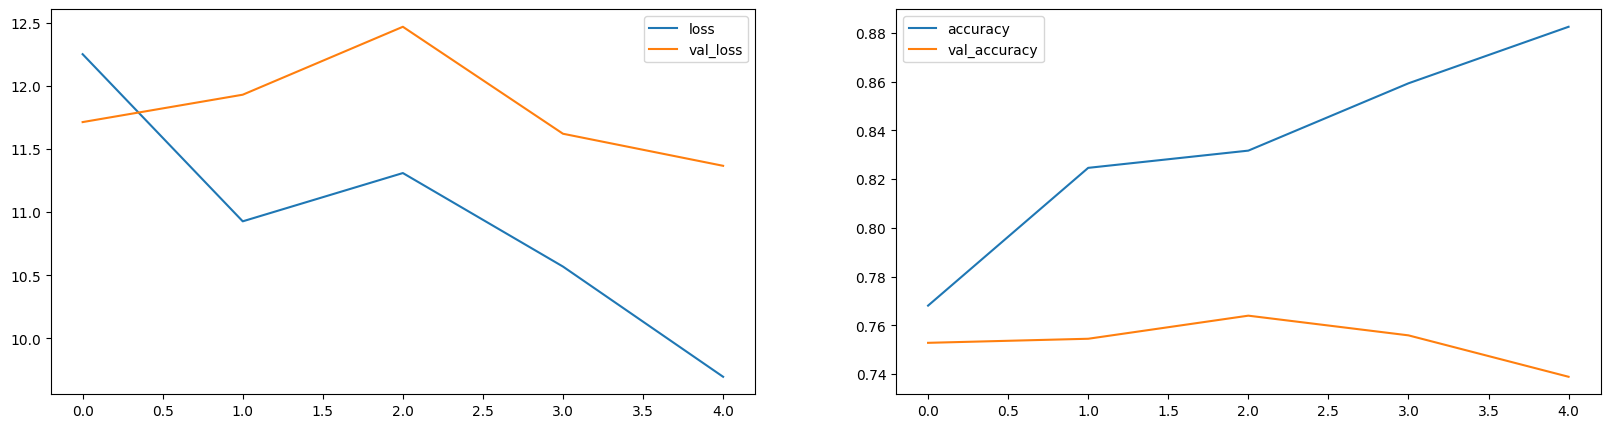

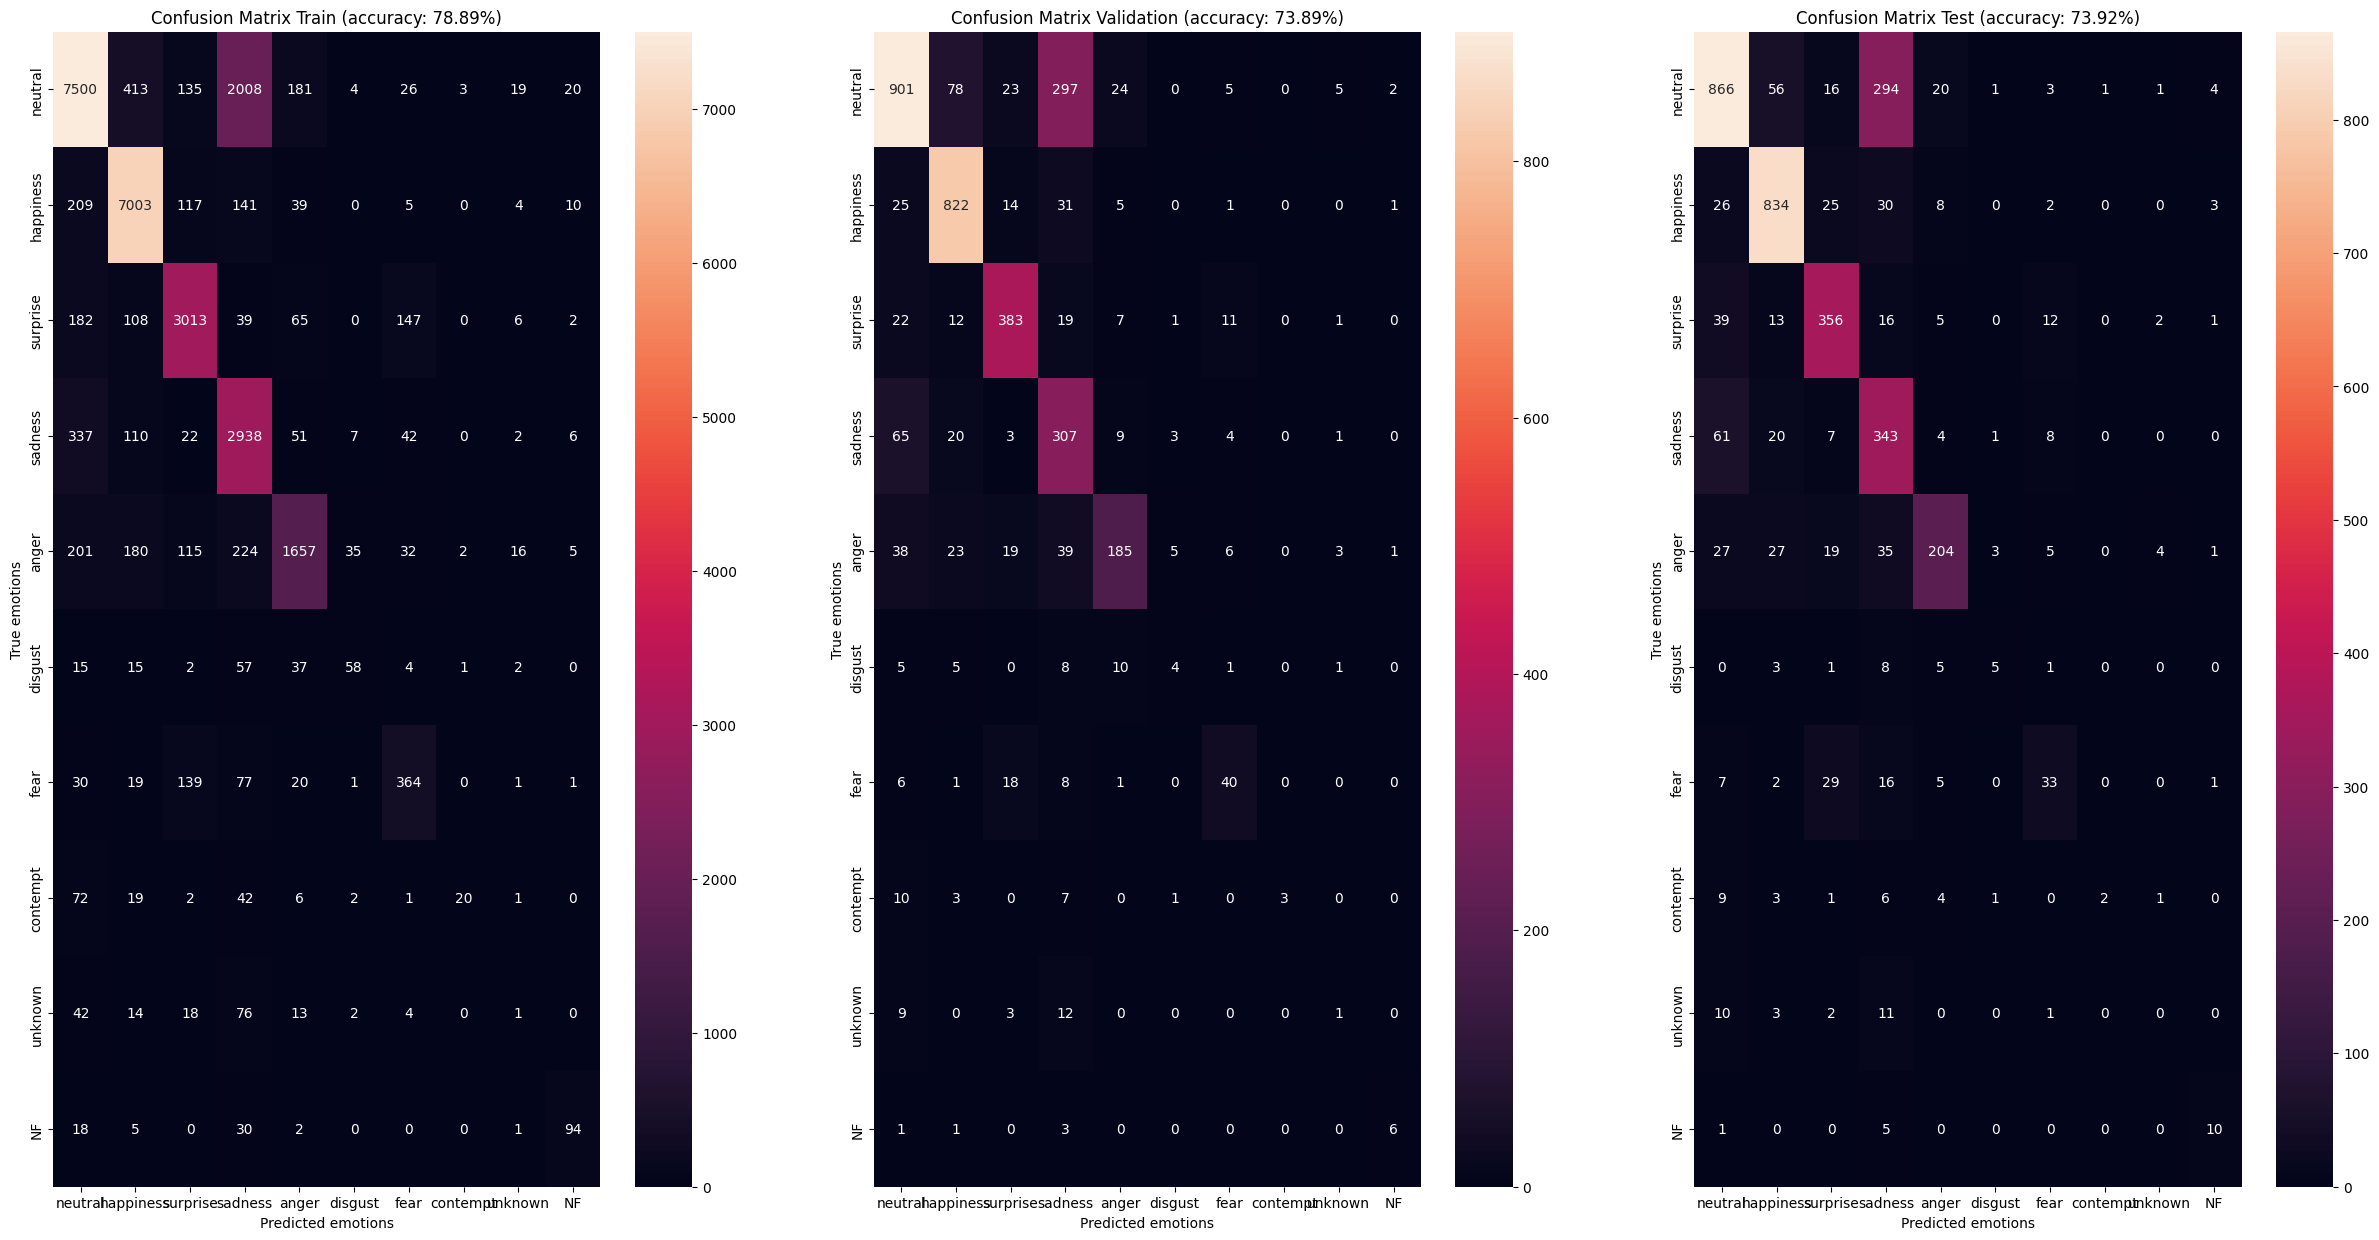

In [43]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

## Test Time Augmentation

---

In [47]:
model = load_model('models/label_smoothed+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
calculateAccuracyWithTTA(ds_test_plus,model)

  0%|          | 0/3 [00:00<?, ?it/s]

28/28 [==============================] - 3s 107ms/step


 33%|███▎      | 1/3 [00:03<00:06,  3.18s/it]

28/28 [==============================] - 3s 104ms/step


 67%|██████▋   | 2/3 [00:06<00:03,  3.03s/it]

28/28 [==============================] - 3s 104ms/step


100%|██████████| 3/3 [00:09<00:00,  3.00s/it]

Accuracy obtained with Test Time Augmentation is: 73.42%
